In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import qiskit.quantum_info as qi



#from qiskit import Aer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature import settings
from qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.primitives import Estimator


In [2]:
def reset_intermediate_info():
    global intermediate_info
    intermediate_info.clear()
    print(intermediate_info)
    intermediate_info = {
        'nfev ': [],
        'parameters ': [],
        'energy ': [],
        'stddev ': []
    }

def callback (nfev , parameters , energy , stddev ):
    intermediate_info ['nfev ']. append ( nfev )
    intermediate_info ['parameters ']. append ( parameters )
    intermediate_info ['energy ']. append ( energy )
    intermediate_info ['stddev ']. append ( stddev )

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

In [3]:
def least_Energy(as_problem):
    as_num_particles = as_problem.num_particles
    as_num_spatial_orbitals = as_problem.num_spatial_orbitals
    as_fermionic_hamiltonian = as_problem.hamiltonian
    as_second_q_op = as_fermionic_hamiltonian.second_q_op()
    energy_arr = []
    ansatz_order = []
    opt_order=[]

    print("Number of particles: {}".format(as_num_particles))
    print("Number of spartial orbitals: {}".format(as_num_spatial_orbitals))

    qubit_op, mapper = fermion_to_qubit(as_problem, as_second_q_op, "Pa", z2symmetry_reduction=None)

    as_init_state = HartreeFock(as_num_spatial_orbitals,as_num_particles,mapper)

    
    
    uccsd = UCCSD(as_num_spatial_orbitals,as_num_particles,mapper,initial_state=as_init_state, generalized=True)
    twolocal = TwoLocal(as_num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=as_init_state)
    ansatzs=[uccsd,twolocal]
    iter = [250,1000]
    ansatzs_name=['UCCSD','Two local']
    
    opt_names = ['COBYLA','SPSA','L-BFGS-B'] 
    noiseless_estimator = Estimator()

    for k in range(2):
        ansatz = ansatzs[k]
        ansatz_name= ansatzs_name[k]
        MAX_ITER = iter[k]
        opt_arr = [COBYLA(maxiter=MAX_ITER),SPSA(maxiter=MAX_ITER),L_BFGS_B(maxiter=MAX_ITER)]
        for k in range(3):
            reset_intermediate_info()
            optimizer = opt_arr[k]
            opt_name = opt_names[k]
            vqe = VQE(noiseless_estimator, ansatz, optimizer, callback = callback)
            result = vqe.compute_minimum_eigenvalue(qubit_op)
            # electronic_structure_result = as_problem.interpret(result)

            core = as_problem.hamiltonian.constants['ActiveSpaceTransformer']
            #repulsion = as_problem.hamiltonian.constants['nuclear_repulsion_energy']

            vqe_result = result.eigenvalue.real #+shift

            exact_energy = exact_solver(qubit_op, as_problem).total_energies[0].real

            # convergence_energy = intermediate_info['energy '][-1]
            dimer_energy = vqe_result+ core
            Co_Li_energy = dimer_energy

            energy_arr.append(Co_Li_energy)
            ansatz_order.append(ansatz_name)
            opt_order.append(opt_name)
            
            plt.plot(range(len(intermediate_info['energy '])), intermediate_info['energy '] + core )
            plt.axhline(exact_energy, color = 'r', linewidth = 1, label = 'exact energy')
            plt.title('{0},{1}'.format(ansatz_name , opt_name))
            plt.xlabel('VQE Iterations')
            plt.ylabel('Energy')
            plt.grid()
            plt.legend()
            plt.show()
    
    return energy_arr, ansatz_order, opt_order

intermediate_info = {
'nfev ': [],
'parameters ': [],
'energy ': [],
'stddev ': []
}


basis = 'cc-pvdz'
settings.use_pauli_sum_op = False

Number of particles: (3, 1)
Number of spartial orbitals: 3
{}


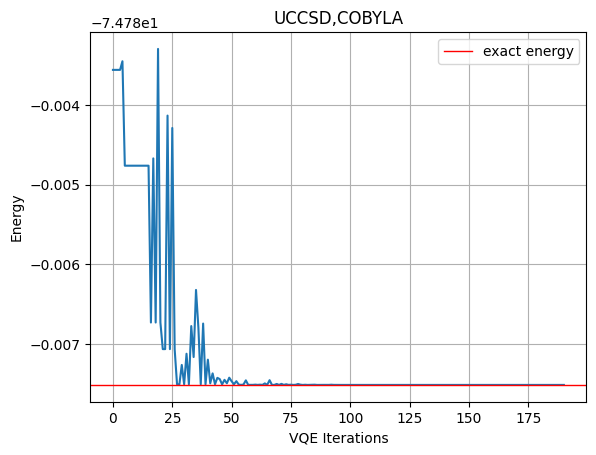

{}


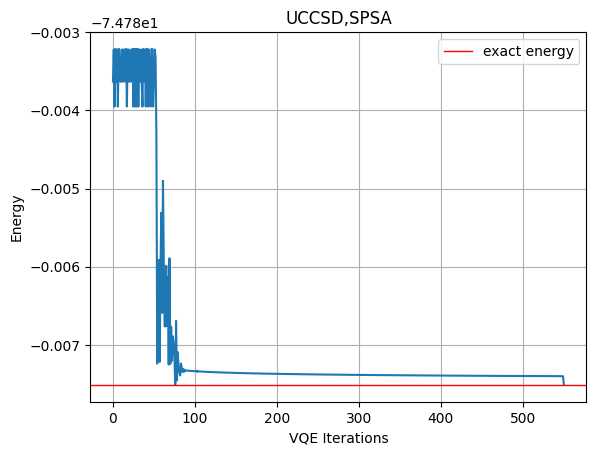

{}


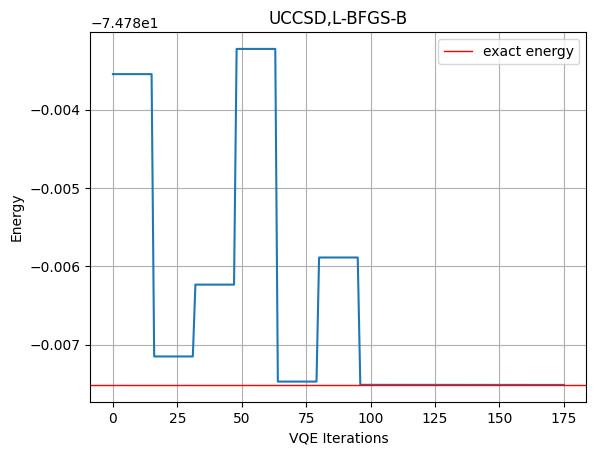

{}


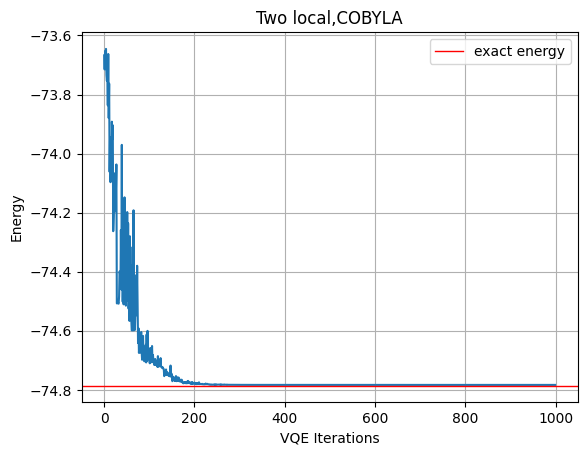

{}


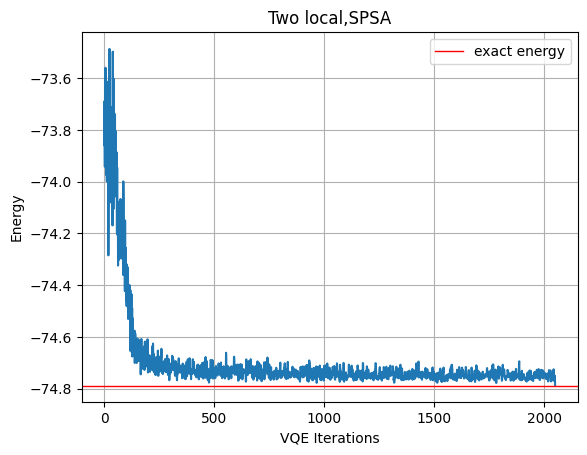

{}


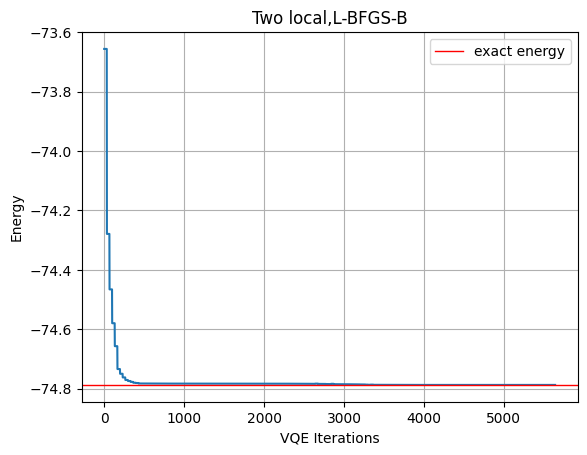

[-74.78751307459339, -74.78751307462349, -74.78751307461255, -74.7834227401651, -74.7851106019038, -74.78751300755863]
optimal_calc :
anstaz:  UCCSD
optimizer:  SPSA
Energy:  -74.78751307462349


In [6]:
O_monomer_atoms = ["O"]
O_monomer_coords = [(0,0,0)]
O_monomer_charge = 0
O_monomer_multiplicity = 3

O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((3,1), 3)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

O_monomer_energy = e

In [ ]:
[-74.78751307459339, -74.78751307462349, -74.78751307461255, -74.7834227401651, -74.7851106019038, -74.78751300755863]
[-74.42349545016329, -74.62583004170482, -74.7875130608949, -74.06552897808263, -74.46923558602839, -74.78605738725356]
[-7.432419848997446, -7.432419879671084, -7.432419879671082, -7.432419863575959, -7.432391311055545, -7.43241987948282]
[-1381.3044887486176, -1381.3511645910166, -1381.3541738893057, -1381.2726874313214, -1381.2840659292199, -1381.3238127255668]


In [ ]:
O_E_arr=[-74.78751307459339, -74.78751307462349, -74.78751307461255, -74.7834227401651, -74.7851106019038, -74.78751300755863]
Li_E_arr=[-7.432419848997446, -7.432419879671084, -7.432419879671082, -7.432419863575959, -7.432391311055545, -7.43241987948282]
Co_E_arr = [-1381.3044887486176, -1381.3511645910166, -1381.3541738893057, -1381.2726874313214, -1381.2840659292199, -1381.3238127255668]

Number of particles: (5, 3)
Number of spartial orbitals: 5
{}


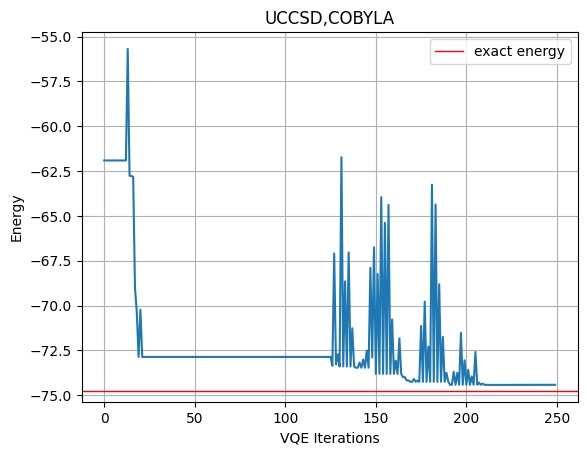

{}


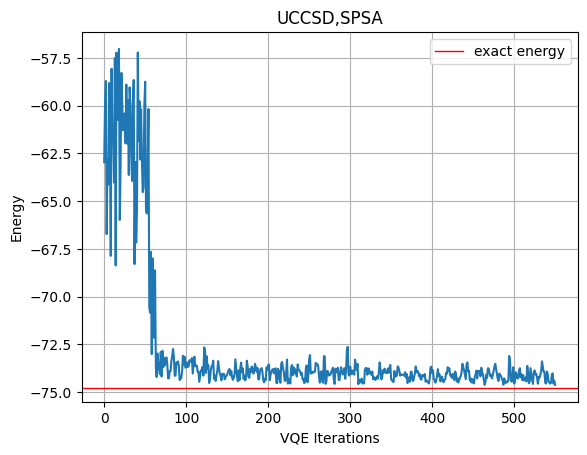

{}


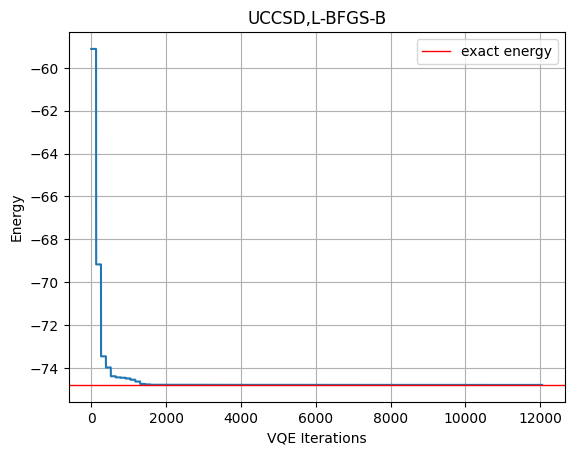

{}


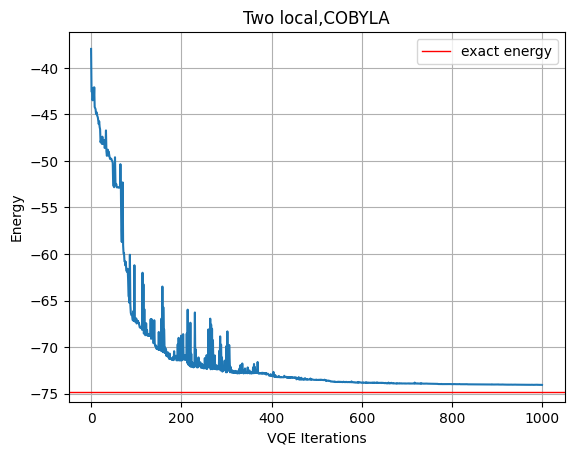

{}


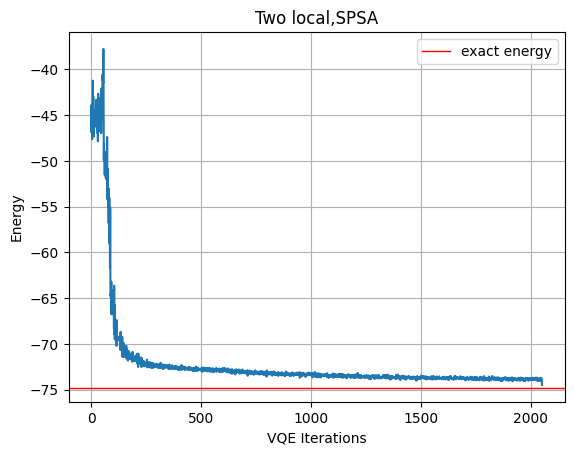

{}


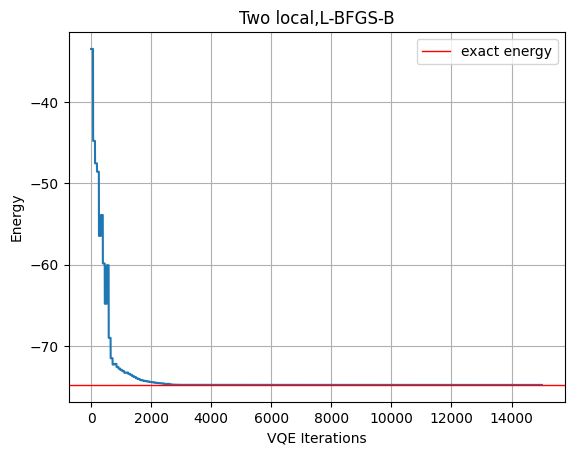

[-74.42349545016329, -74.62583004170482, -74.7875130608949, -74.06552897808263, -74.46923558602839, -74.78605738725356]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -74.7875130608949


In [8]:
O_monomer_atoms = ["O"]
O_monomer_coords = [(0,0,0)]
O_monomer_charge = 0
O_monomer_multiplicity = 3

O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((5,3), 5)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

O_monomer_energy = e

Number of particles: (2, 1)
Number of spartial orbitals: 2
{}


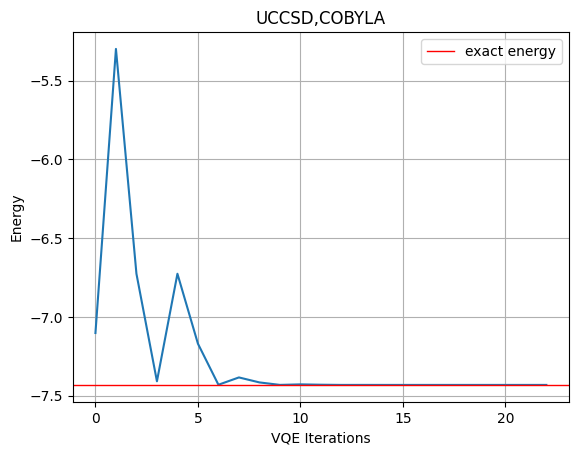

{}


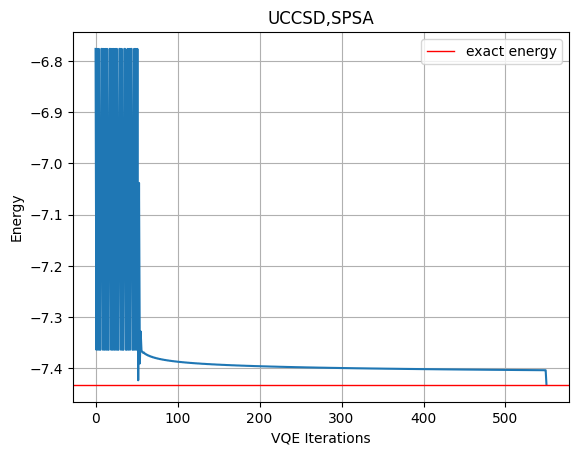

{}


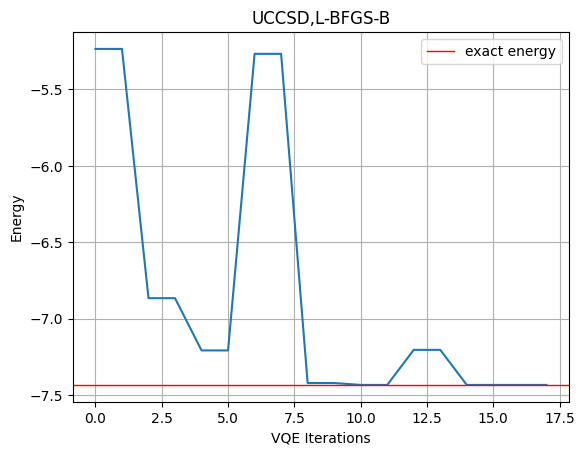

{}


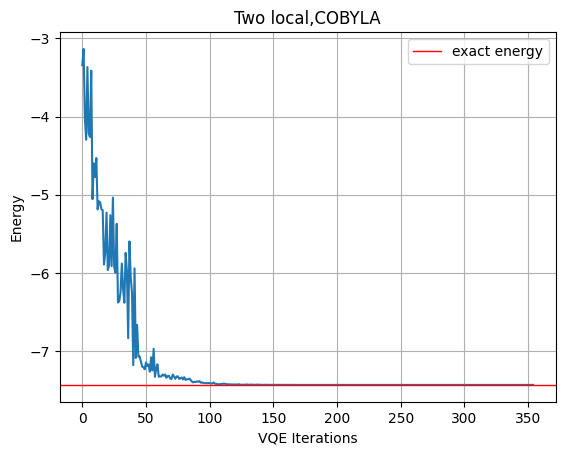

{}


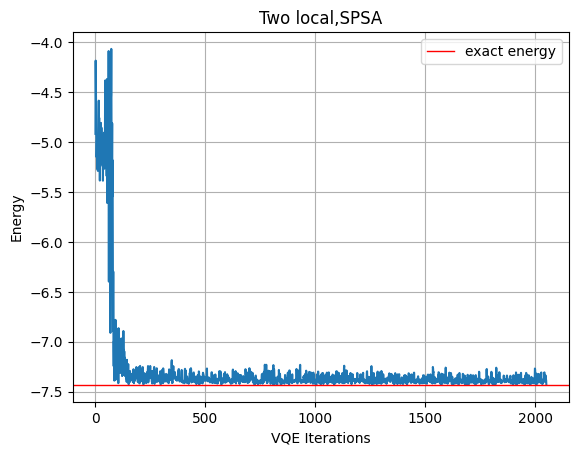

{}


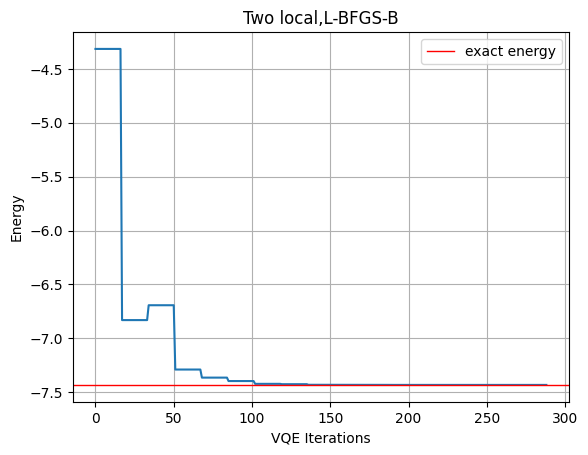

[-7.432419848997446, -7.432419879671084, -7.432419879671082, -7.432419863575959, -7.432391311055545, -7.43241987948282]
optimal_calc :
anstaz:  UCCSD
optimizer:  SPSA
Energy:  -7.432419879671084


In [4]:
O_monomer_atoms = ["Li"]
O_monomer_coords = [(0,0,0)]
O_monomer_charge = 0
O_monomer_multiplicity = 2

O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()

num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((2,1), 2)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem)


print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

Li_monomer_energy = e

Number of particles: (6, 3)
Number of spartial orbitals: 6
{}


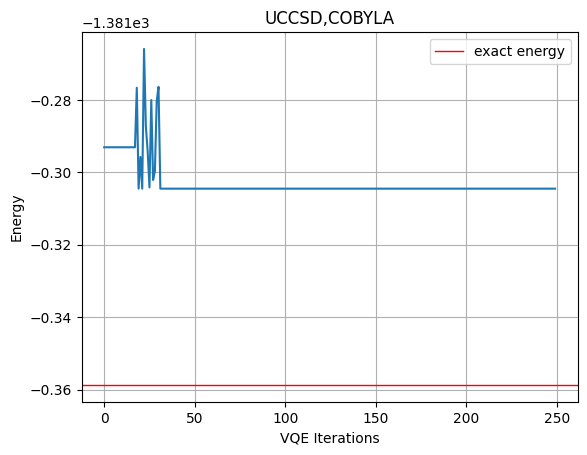

{}


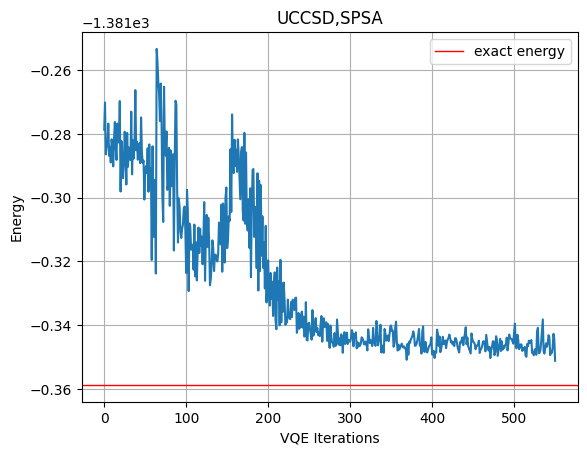

{}


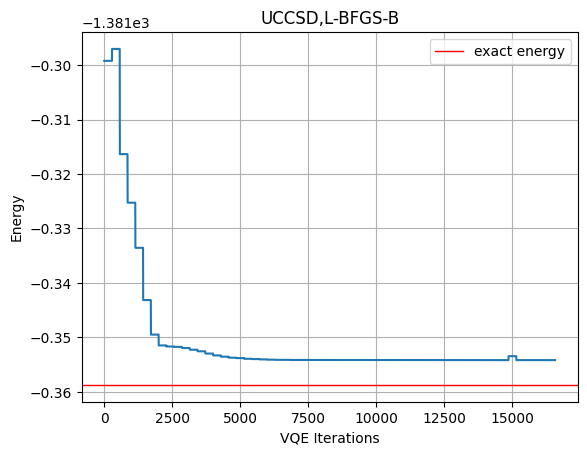

{}


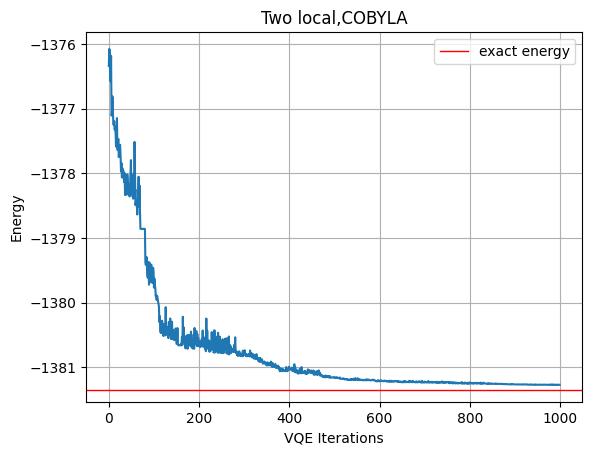

{}


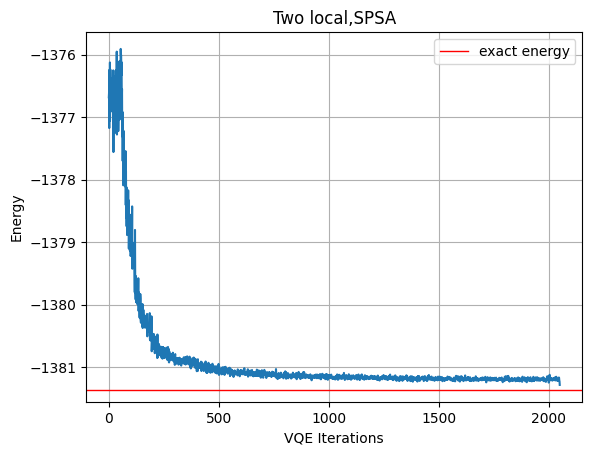

{}


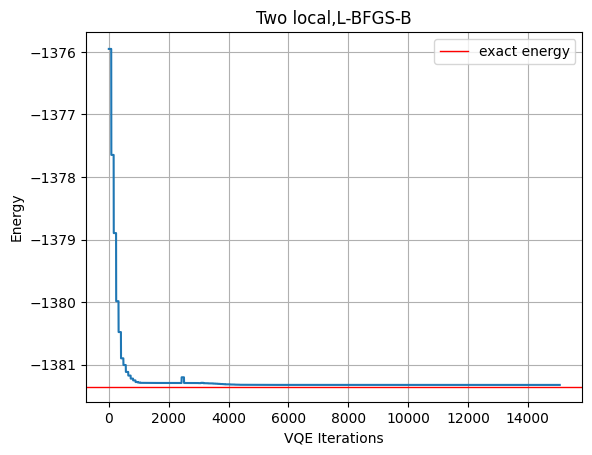

[-1381.3044887486176, -1381.3511645910166, -1381.3541738893057, -1381.2726874313214, -1381.2840659292199, -1381.3238127255668]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -1381.3541738893057


In [5]:
O_monomer_atoms = ["Co"]
O_monomer_coords = [(0,0,0)]
O_monomer_charge = 0
O_monomer_multiplicity = 4

O_Li_moleculeinfo = MoleculeInfo(O_monomer_atoms, O_monomer_coords, charge=O_monomer_charge, multiplicity=O_monomer_multiplicity)

driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()

num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,3), 6)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem)


print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

Co_monomer_energy = e

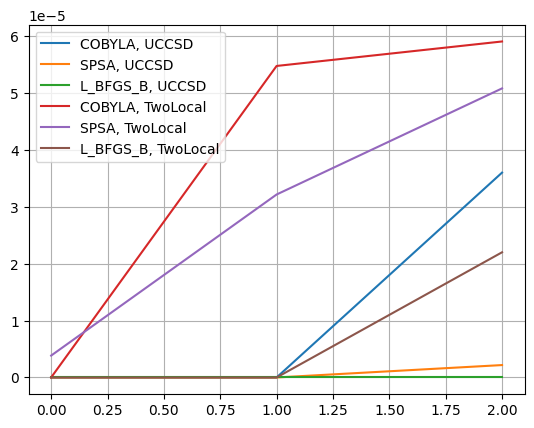

In [15]:
O_E_arr=[-74.78751307459339, -74.78751307462349, -74.78751307461255, -74.7834227401651, -74.7851106019038, -74.78751300755863]
Li_E_arr=[-7.432419848997446, -7.432419879671084, -7.432419879671082, -7.432419863575959, -7.432391311055545, -7.43241987948282]
Co_E_arr = [-1381.3044887486176, -1381.3511645910166, -1381.3541738893057, -1381.2726874313214, -1381.2840659292199, -1381.3238127255668]

monomoer_calc_arr = [[],[],[],[],[],[]]
opt_arr = ['COBYLA','SPSA','L_BFGS_B','COBYLA','SPSA','L_BFGS_B']
ansatz_arr = ['UCCSD','UCCSD','UCCSD',"TwoLocal","TwoLocal","TwoLocal"]

for k in range(6):
    O_E = (O_E_arr[k] +74.78751307461255)/74.78751307461255
    Li_E = (Li_E_arr[k] +7.432419879671082)/7.432419879671082
    Co_E = (Co_E_arr[k] +1381.3541738893057)/1381.3541738893057
    monomoer_calc_arr[k].append(Li_E)
    monomoer_calc_arr[k].append(O_E)
    monomoer_calc_arr[k].append(Co_E)
    plt.plot(monomoer_calc_arr[k],label='{0}, {1}'.format(opt_arr[k],ansatz_arr[k]))
plt.grid()
plt.legend()
plt.show()